### IMPORTING MODULES

In [1]:

import os
import PyPDF2

#Data Loading/Data Manipulation
import pandas as pd
import numpy as np

#nltk
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing and model training 
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Extracting text from pdfs
from pdfminer.high_level import extract_text

In [2]:
#Making empty Dataset
def make_dataframe():
    df=pd.DataFrame()
    df["ID"]=None
    df["Resume"]=None
    df["Category"]=None
    df["Post"]=None
    return df

In [3]:
#Making DataFrame from pdfs
def pdf_to_dataframe(category,folder,length):
    x = [os.path.join(r,file) for r,d,f in os.walk(folder) for file in f]
    d=make_dataframe()
    d["ID"]=x
    for i in d.index:
        d["Category"][i]=category
        d["Post"][i]=category
    for i in d.index:
        data=extract_text(d['ID'][i])
        d["Resume"][i]=data
    for i in d.index:
            d["ID"][i]=str(x[i])[-4-length:-4:1]
    return d

In [4]:
def take_resumes():
    n=int(input("Enter the number of categories you want to analyse: "))
    ln=int(input("Enter the length of ID: "))
    df=make_dataframe()
    for i in range(n):
        print("Enter the details of ",i+1,"th category")
        Category=input("Enter the Category: ")
        Resumes=input("Enter the path of folder containing resumes: ")
        print("\n")
        s = pdf_to_dataframe(Category,Resumes,ln)
        df=df.append(s)
    df.index = range(len(df))
    print("Data fed successfully!! Please wait for a while !!\n")
    return df

In [5]:
def skills_dataset():
    Skills= pd.read_csv("SkillsList.csv")
    SkillsList=Skills['Skills'].tolist()
    return SkillsList

In [6]:
def show(df):
    print("\t\t\t-----------INFORMATION OF RESUMES-----------")
    print(df.info())

In [7]:
def get_excel_resume(df):
    d=df.drop(["Clean_Resume","skills","Post"],axis=1)
    d.to_excel("Resume Record.xlsx")
    print("Your resume excel file is ready.\n")

In [8]:
def clean_resume(data):
    clean = []
    for i in range(data.shape[0]):
        review = re.sub(
            '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
            " ",
            data["Resume"].iloc[i],
        )
        review = review.lower()
        review = review.split()      
        lm = WordNetLemmatizer()
        review = [
            lm.lemmatize(word)
            for word in review
            if not word in set(stopwords.words("english"))
        ]
        review = " ".join(review)
        clean.append(review)
    data["Clean_Resume"] = clean
    return data

In [9]:
#Function for extracting skills
def extract_skills(input_text):
    SkillsList=skills_dataset()
    stop_words = set(nltk.corpus.stopwords.words('english'))         #to get set of all stopwords of english language
    word_tokens = nltk.tokenize.word_tokenize(input_text)          #to tokenize the word
 
    # remove the stop words and punctuation
    filtered_tokens = [w for w in word_tokens if w not in stop_words and w.isalpha()]
 
    # generate bigrams and trigrams (such as artificial intelligence)
    bigrams_trigrams = list(map(' '.join, nltk.everygrams(filtered_tokens, 2, 3)))    # return all the bigrams and trigrams from filtered tokens
 
    # set to keep the results in.
    found_skills = set()
 
    # search for each token in our skills database
    for token in filtered_tokens:
        if token.lower() in SkillsList:
            found_skills.add(token)
    # search for each bigram and trigram in our skills database
    for ngram in bigrams_trigrams:
        if ngram.lower() in SkillsList:
            found_skills.add(ngram)
 
    return found_skills

In [10]:
def unique_skills(x):
    return list(set(x))

In [11]:
def get_skills(data):
    data["skills"] = data["Clean_Resume"].str.lower().apply(extract_skills)
    data["skills"] = data["skills"].apply(unique_skills)
    return data

In [12]:
def get_excel_skill(df):
    d=df.drop(["Resume","Clean_Resume","Post"],axis=1)
    d.to_excel("Skills Record.xlsx")
    print("Your skills file is ready\n")

In [13]:
def visualization(df):
    print ("Displaying the distinct categories of resume and the number of records belonging to each category:\n\n")
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)     
    ax=sns.countplot(x='Category', data=df)      
    for p in ax.patches:     
        ax.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
    plt.show()

In [14]:
def model_trainings(data):
    le = preprocessing.LabelEncoder()
    le.fit(data['Post'])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    text=data['Clean_Resume'].values          
    target=data['Post'].values            
    vect=TfidfVectorizer(
        sublinear_tf=True,          
        stop_words='english',       
        max_features=2000)   
    vect.fit(text)
    Word_feature=vect.transform(text)
    x_train, x_test, y_train, y_test=train_test_split(Word_feature, target, random_state=0, test_size=0.4)
    l=[]
    l.append(x_train)
    l.append(x_test)
    l.append(y_train)
    l.append(y_test)
    return l
    

In [15]:
def model_insights(l):
    x_train=l[0]
    x_test=l[1]
    y_train=l[2]
    y_test=l[3]
    model_s=SVC()
    model_s.fit(x_train, y_train)
    model_k=KNeighborsClassifier()
    model_k.fit(x_train, y_train)
    model_d=DecisionTreeClassifier()
    model_d.fit(x_train, y_train)
    m=[]
    m.append(model_s)
    m.append(model_k)
    m.append(model_d)
    prediction_s=model_s.predict(x_test)
    prediction_k=model_k.predict(x_test)
    prediction_d=model_d.predict(x_test)
    print("The train models are:\n1.Support Vector Machine\n2.KNeighbors Classifier\n3.Decision Tree Classifer\n")
    print("---------------SUPPORT VECTOR MACHINE------------\n")
    print("training Score: {:.2f}".format(model_s.score(x_train, y_train)))
    print("test Score: {:.2f}\n".format(model_s.score(x_test, y_test)))
    print("model report: %s: \n %s\n" % (model_s, metrics.classification_report(y_test, prediction_s)))
    cm_s=confusion_matrix(y_test,prediction_s)            
    print("---------------KNEIGHBORS CLASSIFIER-------------\n")
    print("training Score: {:.2f}".format(model_k.score(x_train, y_train)))
    print("test Score: {:.2f}\n".format(model_k.score(x_test, y_test)))
    print("model report: %s: \n %s\n" % (model_k, metrics.classification_report(y_test, prediction_k)))
    cm_k=confusion_matrix(y_test,prediction_k)
    print("---------------DECISION TREE CLASSIFIER------------\n")
    print("training Score: {:.2f}".format(model_d.score(x_train, y_train)))
    print("test Score: {:.2f}\n".format(model_d.score(x_test, y_test)))
    print("model report: %s: \n %s\n" % (model_d, metrics.classification_report(y_test, prediction_d)))
    cm_d=confusion_matrix(y_test,prediction_d)
    plt.figure(figsize=(30,10))
    plt.subplot(1,3,1)
    sns.heatmap(cm_s,annot=True,cbar=False)
    plt.title("SUPPORT VECTOR MACHINE")
    plt.subplot(1,3,2)
    sns.heatmap(cm_k,annot=True,cbar=False)
    plt.title("KNEIGHBORS CLASSIFIER")
    plt.subplot(1,3,3)
    sns.heatmap(cm_d,annot=True,cbar=False)
    plt.title("DECISION TREE CLASSIFIER")
    return m
    

In [16]:
def ranking(data):
    data["Score"]=0.0
    category=input('Enter the category for which you want top resumes: ')
    input_skills=input("Enter the skills you want to have : ")
    req_skills = input_skills.lower().split(",")
    c=0
    for i in data.index:
        if data["Category"][i]==category:
            c=c+1
            score = 0
            for x in req_skills:
                if x in data["skills"][i]:
                    score += 1
            req_skills_len = len(req_skills)
            match = round(score / req_skills_len * 100, 1)
            data["Score"][i]=match
    d=data.sort_values(by="Score",ascending=False)
    if(c==0):
        print("Category not found!!")
    else:
        for i in d.index:
            if(d["Score"][i]!=0.0):
                print(d["ID"][i])

### Menu Driven Code

Welcome to Job Application Admitter!!!


Enter the name of your organization: ProgHeads


Hello ProgHeads , Choose what you want to do: 

1.Feed the pdfs of resume
2.Show resume summary
3.Get the excel file of resumes
4.Get the excel file of candidate's skills
5.Visualize the number of categories
6.Get trained model insights
7.Get the ids of top resumes
8.Exit

Enter your choice: 1
Enter the number of categories you want to analyse: 10
Enter the length of ID: 8
Enter the details of  1 th category
Enter the Category: Chef
Enter the path of folder containing resumes: data/CHEF


Enter the details of  2 th category
Enter the Category: Advocate
Enter the path of folder containing resumes: data/ADVOCATE


Enter the details of  3 th category
Enter the Category: Construction
Enter the path of folder containing resumes: data/CONSTRUCTION


Enter the details of  4 th category
Enter the Category: Sales
Enter the path of folder containing resumes: data/SALES


Enter the details of  5 th category


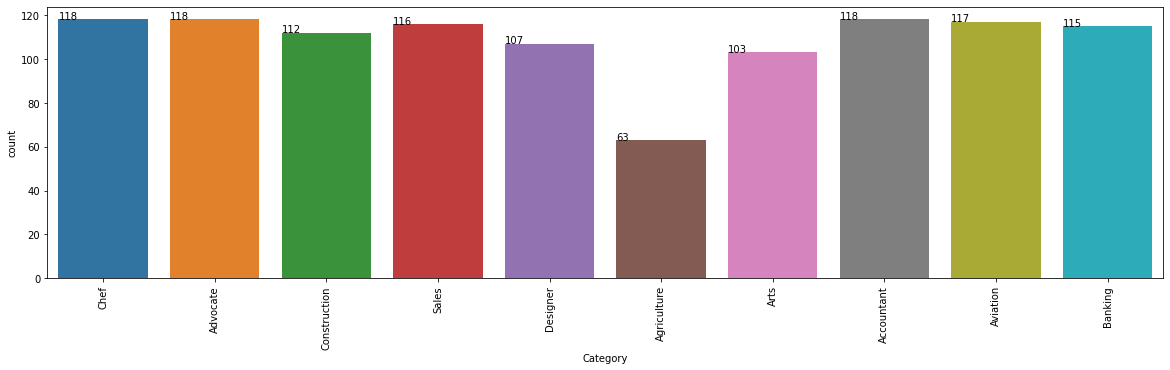


Enter your choice: 6
The train models are:
1.Support Vector Machine
2.KNeighbors Classifier
3.Decision Tree Classifer

---------------SUPPORT VECTOR MACHINE------------

training Score: 1.00
test Score: 0.75

model report: SVC(): 
               precision    recall  f1-score   support

  Accountant       0.93      0.84      0.88        44
    Advocate       0.44      0.81      0.57        37
 Agriculture       1.00      0.30      0.47        23
        Arts       0.75      0.49      0.59        49
    Aviation       0.79      0.86      0.82        43
     Banking       0.73      0.87      0.80        47
        Chef       0.93      0.82      0.87        49
Construction       0.93      0.83      0.88        48
    Designer       0.94      0.68      0.79        50
       Sales       0.57      0.80      0.67        45

    accuracy                           0.75       435
   macro avg       0.80      0.73      0.73       435
weighted avg       0.80      0.75      0.75       435


-------

<ipython-input-16-0de871bb01cf>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Score"][i]=match


28359817
39674178
17556527
18132924
18365791
18569929
18635654
18669563
19446337
19545827
20082776
20253563
98559931
87635012
82649935
20345168
78403342
78257294
75286906
63137898
62809577
59403481
53640713
50222417
49997097
49204385
43685045
17407184
17306905
16237710
13491889
10674770
11759079
12065211
12202337
12338274
12442909
12780508
12802330
13072019
13130984
13294301
13701259
15906625
14055988
14126433
14224370
14449423
14470533
14491649
14496667
15289348
15363277
15592167
15821633
42487883
39115899
21338490
38847011
25867805
25862026
25846894
25749150
25547145
25462793
25127518
25067742
24817041
24799301
24703009
24294778
24103168
23734441
23636277
23513618
23438112
23416654
23387174
21031285
23139819
22925443
22465498
21853199
21794875
20624984
26065877
26975573
30304575
37997506
37370455
36425270
36024962
35554162
34816637
34198885
33527446
31602598
30813919
30361788
29999135
27558837
29821051
29456173
29050809
28969385
28939941
28614791
20393721
28298773
27980446
27637576
2

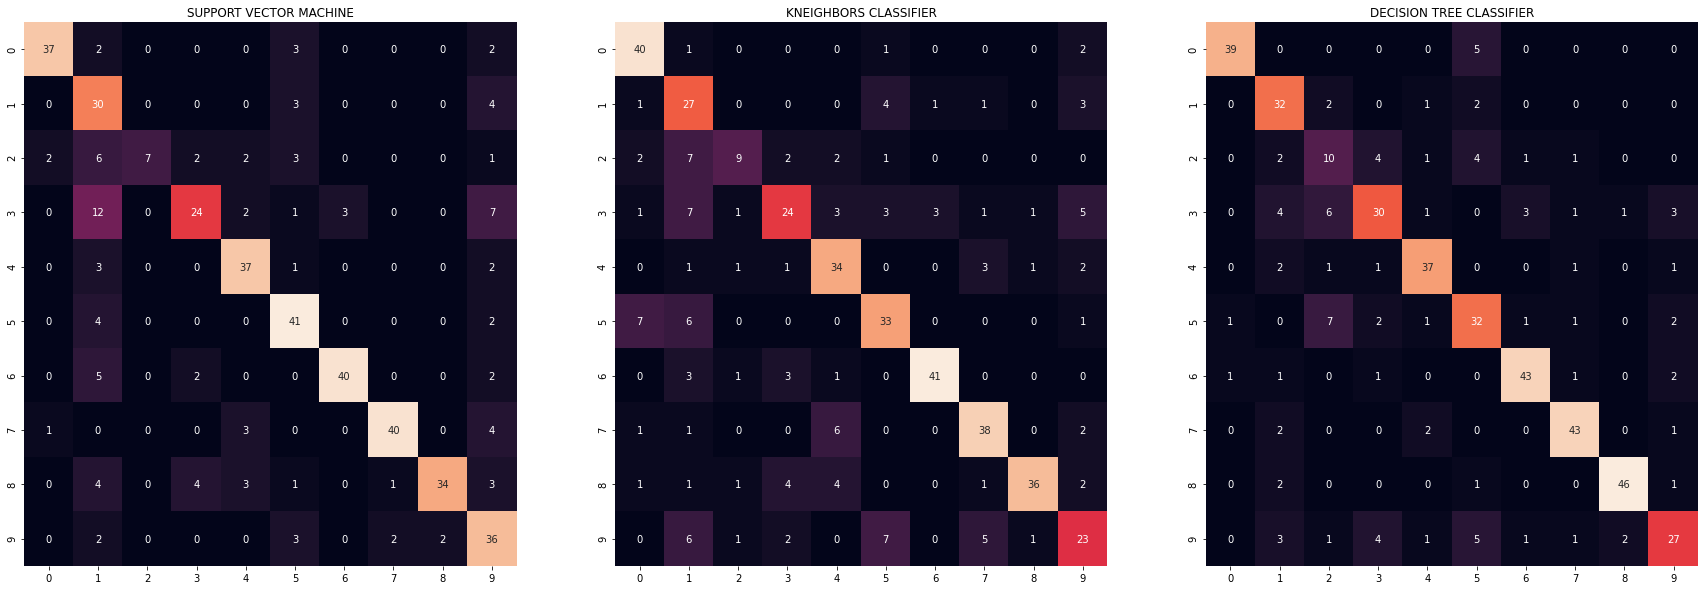

In [17]:
print("Welcome to Job Application Admitter!!!") 
name=input("\n\nEnter the name of your organization: ")
print("\n\nHello",name,", Choose what you want to do: ")
print("\n1.Feed the pdfs of resume\n2.Show resume summary\n3.Get the excel file of resumes\n4.Get the excel file of candidate's skills\n5.Visualize the number of categories\n6.Get trained model insights\n7.Get the ids of top resumes\n8.Exit")

while(1):
    try:
        choice=int(input("\nEnter your choice: "))
        if(choice==1):
            try:
                data=take_resumes()
                SkillsList=skills_dataset()
                data=clean_resume(data)
                data=get_skills(data)
                l=model_trainings(data)
            except:
                print("Error! Please try again!!")
        elif(choice==2):
            try:
                show(data)
            except:
                print("Error! Please try again!!")
        elif(choice==3):
            try:
                get_excel_resume(data)
            except:
                print("Error! Please try again!!")
        elif(choice==4):
            try:
                get_excel_skill(data)
            except:
                print("Error! Please try again!!")
        elif(choice==5):
            try:
                visualization(data)
            except:
                print("Error! Please try again!!")
        elif(choice==6):
            try:
                m=model_insights(l)
            except:
                print("Error! Please try again!!")
                
        elif(choice==7):
            try:
                ranking(data)
            except:
                print("Error! Please try again!!")
        elif(choice==8):
            try:
                print("Thanks for letting us help you!!!\n\n EXIT.....\n")
                break
            except:
                print("Error! Please try again!!")
        else:
            try:
                print("Enter an appropriate choice")
            except:
                print("Error! Please try again!!")
    except:
            print("Error! Please try again!!")